# Proximal Policy Optimization (PPO) Clipped Objective in Pytorch

This implementation use the PPO clipped objective from [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347.pdf) for policy gradient. And use the same old TD error for critic update

The policy loss $L(\theta)_t$:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_t(\theta)=\dfrac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$L(\theta)_t=min(r_t(\theta)\hat{A}, clip(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A})$  

And it caculate the general advantage estimation as formula 11, 12 in the paper:  
&nbsp;&nbsp;&nbsp;&nbsp;<img src="ppo_gae.png" width="500"/> 

Where formula 12 is the TD error for the critic loss.

In [1]:
%matplotlib inline
from IPython import display
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Normal, Categorical

import numpy as np
import random
import os
import gym

In [2]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

In [3]:
def save_torch_model(model, filename):
  if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))
  torch.save(model.state_dict(), filename)

def load_torch_model(model, filename):
  model.load_state_dict(torch.load(filename))

In [4]:
def plot(index, score, actor_loss, critic_loss):
    clear_output(True)
    plt.figure(figsize=(18,5))
    plt.subplot(131)
    plt.title('%d, score: %.2f' % (index, score[-1]))
    plt.plot(score)
    plt.subplot(132)
    plt.title('%d, actor_loss' % (index))
    plt.plot(actor_loss)
    plt.subplot(133)
    plt.title('%d, critic_loss' % (index))
    plt.plot(critic_loss)
    plt.show()

In [5]:
class PolicyNet(nn.Module):
  def __init__(self, input_size, output_size):
    super(PolicyNet, self).__init__()
    self.l1_linear = nn.Linear(input_size, 64)
    self.l2_linear = nn.Linear(64, 32)
    self.l3_linear = nn.Linear(32, output_size)
    nn.init.kaiming_normal_(self.l1_linear.weight)
    nn.init.kaiming_normal_(self.l2_linear.weight)
    self.l3_linear.weight.data.zero_()
    
  def forward(self,x):
    out = F.relu(self.l1_linear(x))
    out = F.relu(self.l2_linear(out))
    out = F.tanh(self.l3_linear(out))
    return out

In [6]:
class ValueNet(nn.Module):
  def __init__(self, input_size):
    super(ValueNet,self).__init__()
    self.l1_linear = nn.Linear(input_size, 64)
    self.l2_linear = nn.Linear(64, 32)
    self.l3_linear = nn.Linear(32, 1)
    nn.init.kaiming_normal_(self.l1_linear.weight)
    nn.init.kaiming_normal_(self.l2_linear.weight)
    self.l3_linear.weight.data.zero_()

  def forward(self, x):
    out = F.relu(self.l1_linear(x))
    out = F.relu(self.l2_linear(out))
    out = self.l3_linear(out)
    return out

In [7]:
class PPO():
  def __init__(self, env, steps_in_state = 1):
    self.is_training = True
    self.steps_in_state = steps_in_state
    self.actor = PolicyNet(env.observation_space.shape[0] * steps_in_state, env.action_space.shape[0])
    self.actor_prime = PolicyNet(env.observation_space.shape[0] * steps_in_state, env.action_space.shape[0])
    self.critic = ValueNet(env.observation_space.shape[0] * steps_in_state)
    if use_cuda:
      self.actor.cuda()
      self.actor_prime.cuda()
      self.critic.cuda()
    # copy the weight in actor, make sure actor and actor_prime start with same weights
    self.actor_prime.load_state_dict(self.actor.state_dict())
    self.env = env
    self.range_scale = (env.action_space.high[0] - env.action_space.low[0]) / 2.0
    self._gamma = 0.95
    self._lambda = 0.95
    self._epsilon = 0.1

  def pick_action(self, state):
    action = self.actor(state)
    # add noise
    if self.is_training:
      action_dist = Normal(action, 0.5)
      action = action_dist.sample()
    else:
      action = action.item()
    return np.clip(action, -1.0, 1.0)
  
  def update_ppo_clip(self, batch):
    (states, actions, rewards, next_states, ended) = zip(*batch)
    states_tensor = torch.stack(states)
    actions_tensor = FloatTensor(actions).view(-1,1)
    rewards_tensor = FloatTensor(rewards).view(-1,1)
    next_states_tensor = torch.stack(next_states)
    ended_tensor = FloatTensor(ended).view(-1,1)
    
    critic_loss = rewards_tensor + self._gamma * (1 - ended_tensor) * self.critic(next_states_tensor) - self.critic(states_tensor)
    advantage = []
    for delta in critic_loss.view(-1).tolist()[::-1]:
      adv = delta
      if len(advantage) > 0:
        adv += self._gamma * self._lambda * advantage[0]
      advantage.insert(0, adv)
    advantage_tensor = FloatTensor(advantage).view(-1,1)
                             
    # hardcode standard deviation for the action probability to 0.5 to simplify implementation.
    # the standard deviation maybe able to be learned by the actor?
    action_dist_prime = Normal(self.actor_prime(states_tensor), FloatTensor([0.5]*len(batch)))
    action_dist_old = Normal(self.actor(states_tensor), FloatTensor([0.5]*len(batch)))
    
    # Normal distribution class in Pytroch only provide a log_prob function.
    # so log_prob is used here then torch.exp covert it back to probability ratio. ln(a) - ln(b) = ln(a/b). e^ln(a/b) = a/b
    action_prob_ratio = torch.exp(action_dist_prime.log_prob(actions_tensor) - action_dist_old.log_prob(actions_tensor))
    actor_loss = torch.min(action_prob_ratio * advantage_tensor, \
                           torch.clamp(action_prob_ratio, 1 - self._epsilon, 1 + self._epsilon) * advantage_tensor)
    
    actor_loss = -actor_loss.mean()
    self.actor_prime_optimizer.zero_grad()
    actor_loss.backward(retain_graph=True)
    self.actor_prime_optimizer.step()

    # mean square of critic_loss
    critic_loss = critic_loss * critic_loss
    critic_loss = critic_loss.mean()
    self.critic_coptimizer.zero_grad()
    critic_loss.backward()
    self.critic_coptimizer.step()
    
    return(actor_loss.item(), critic_loss.item())
    
  def train(self, env, episode_limit=1000, batch_size=64, copy_on_episode=10, lr=1e-3, lr_actor=None, lr_critic=None, checkpoint=100):
    lr_actor = lr if lr_actor == None else lr_actor
    lr_critic = lr if lr_critic == None else lr_critic
    
    self.actor_prime_optimizer = torch.optim.Adam(self.actor_prime.parameters(), lr=lr_actor, weight_decay=1e-3)
    self.critic_coptimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1e-3)
    
    best_score = -99999
    running_score = None
    running_actor_loss = None
    running_critic_loss = None
    self.iteration = 0
    graph = {'running_score':[], 'running_actor_loss':[], 'running_critic_loss':[], 'mean_state_value':[]}

    for episode_count in range(episode_limit):
      s0 = env.reset()
      seq = [s0] * self.steps_in_state
      state = FloatTensor(seq).view(-1)
      episode_ended = False
      score = 0
      episode = []
      mean_state_value = []
      while not episode_ended:
        mean_state_value.append(self.critic(state))
        action =  self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step([action * self.range_scale])
        seq = seq[1:]
        seq.append(s1)
        next_state = FloatTensor(seq).view(-1)
        if episode_ended:
          ended = 1
        else:
          ended = 0
        episode.append((state, action, reward, next_state, ended))
        s0 = s1
        state = next_state
        score += reward
        if len(episode) == batch_size or episode_ended:
          if (episode_ended):
            episode.pop()
          if len(episode) > 0:
            (actor_loss, critic_loss) = self.update_ppo_clip(episode)
            if running_actor_loss == None:
              running_actor_loss = actor_loss
              running_critic_loss = critic_loss
            else:
              running_actor_loss = running_actor_loss * 0.9 + actor_loss * 0.1
              running_critic_loss = running_critic_loss * 0.9 + critic_loss * 0.1

          episode = []

      if running_score == None:
        running_score = score
      else:
        running_score = running_score * 0.9 + score * 0.1
        
      if (episode_count + 1) % (checkpoint / 10 ) == 0:
        graph['running_score'].append(running_score)
        graph['running_actor_loss'].append(running_actor_loss)
        graph['running_critic_loss'].append(running_critic_loss)
        graph['mean_state_value'].append(sum(mean_state_value)/len(mean_state_value))
        plot(episode_count + 1, graph['running_score'], graph['running_actor_loss'], graph['running_critic_loss'] )
#         print( graph['running_score'][-1],graph['running_actor_loss'][-1],graph['running_critic_loss'][-1])

      if (episode_count + 1) % checkpoint == 0 and running_score != None:
        if running_score > best_score:
          best_score = running_score
          save_torch_model(self.actor,'model/ppo_actor_best.pth')          
        save_torch_model(self.actor,'model/ppo_actor_iter_%d.pth' %(episode_count+1))
      
      if  (episode_count + 1) % copy_on_episode == 0:
        self.actor.load_state_dict(self.actor_prime.state_dict())
        


In [8]:
env = gym.make('Pendulum-v0')
agent = PPO(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


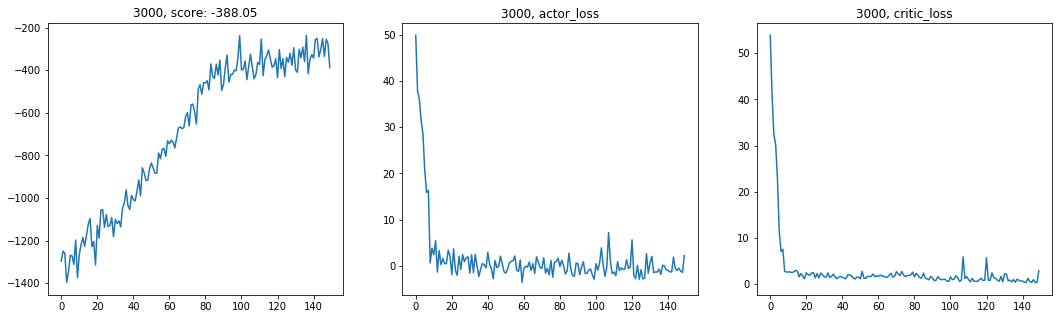

In [10]:
agent.is_training = True
agent.train(env, episode_limit=3000, batch_size=64, copy_on_episode=2, lr_actor=1e-4, lr_critic=1e-3, checkpoint=200)

In [127]:
# run a sample episode with a trained agent
agent.is_training = False
load_torch_model(agent.actor,'model/ppo_actor_best.pth')
state = env.reset()
frames = []
frames.append(env.render(mode='rgb_array'))
ended = False
score = 0
while not ended:
  action = agent.pick_action(FloatTensor([state]).view(-1))
  (state, reward, ended, info) = env.step([action*2])
  score += reward
  frames.append(env.render(mode='rgb_array'))
print(score)

-254.56064613660496


In [128]:
%%capture
def animate(frames):
  fig, ax = plt.subplots()
  ax.grid('off')
  ax.axis('off')
  ims = []
  for i in range(len(frames)):
      im = plt.imshow(frames[i], animated=True)
      ims.append([im])
  ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True, repeat_delay=1000)
  return ani

ani = animate(frames)
ani.save('pendulum_ppo.mp4')

In [129]:
%%HTML
<video width="400" controls loop>
  <source src="pendulum_ppo.mp4" type="video/mp4">
</video>